In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

## Loading Data

In [6]:
basicinfo = pd.read_csv('ListSensors.csv', index_col=0)
rawno2 = pd.read_csv('no2.csv',index_col=0)
rawpm = pd.read_csv('pm25.csv',index_col=0)

# dates of study period
vecdateall = pd.date_range(start="2022-01-01",end="2023-01-01", freq='1h')[0:-1]
vecday = pd.date_range(start="2022-01-01",end="2023-01-01", freq='D')[0:-1]

In [7]:
# setting dates of study period
t1 = "2022-01-01 00:00:00" # first day for analysis
t2 = "2022-12-31 23:00:000" # last day for analysis

indt1 = np.where(vecdateall==t1)[0][0]
indt2 = np.where(vecdateall==t2)[0][0]

pm = rawpm.iloc[indt1:indt2+1,:]
no2 = rawno2.iloc[indt1:indt2+1,:]

pm['Datetime'] = vecdateall
pm = pm.set_index('Datetime')

no2['Datetime'] = vecdateall
no2 = no2.set_index('Datetime')

/var/folders/6v/sphsrdkd5yd0y024lwxvk6q80000gn/T/ipykernel_6050/3317444927.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm['Datetime'] = vecdateall
/var/folders/6v/sphsrdkd5yd0y024lwxvk6q80000gn/T/ipykernel_6050/3317444927.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no2['Datetime'] = vecdateall


In [8]:
# choose Pm or no2 for analysis
data = pm

In [9]:
# Site Type
sitetype = basicinfo['SiteClassification'].unique()
indks = np.where(basicinfo['SiteClassification'] == 'Kerbside')[0]
nks = len(indks)
indrs = np.where(basicinfo['SiteClassification'] == 'Roadside')[0]
nrs = len(indrs)
indub = np.where(basicinfo['SiteClassification'] == 'Urban Background')[0]
nub = len(indub)
indnan = np.where((basicinfo['SiteClassification']!='Urban Background') 
                          & (basicinfo['SiteClassification']!='Roadside') 
                          & (basicinfo['SiteClassification']!='Kerbside'))[0]

toth, nsite = no2.shape 
totd = int(toth/24)

nnan = len(indnan)

In [10]:
# Site Name
podid = basicinfo['SiteCode']

In [11]:
basicinfo['SiteClassification'].value_counts()

Roadside            262
Urban Background     51
Kerbside              2
Name: SiteClassification, dtype: int64

## Daily Mean
Calculating mu of daily NO2 and PM concentrations

In [12]:
mudno2 = np.zeros([totd,nsite])*np.nan
mudpm = np.zeros([totd,nsite])*np.nan
for i in np.arange(0,totd):
    row1 = i*24
    row2 = (i+1)*24
    
    tempno2 = no2.values[row1:row2,:]
    temppm = pm.values[row1:row2,:]
    
    mudno2[i,:] = np.nanmean(tempno2,axis=0)  # Each row represents one day; Each column represents one site.
    mudno2[i,np.sum(np.isnan(tempno2),axis=0) >= 15] = np.nan
    mudpm[i,:] = np.nanmean(temppm,axis=0) # Each row represents one day; Each column represents one site.
    mudpm[i,np.sum(np.isnan(temppm),axis=0) >= 15] = np.nan

/var/folders/6v/sphsrdkd5yd0y024lwxvk6q80000gn/T/ipykernel_6050/3312168342.py:10: RuntimeWarning: Mean of empty slice
  mudno2[i,:] = np.nanmean(tempno2,axis=0)  # Each row represents one day; Each column represents one site.
/var/folders/6v/sphsrdkd5yd0y024lwxvk6q80000gn/T/ipykernel_6050/3312168342.py:12: RuntimeWarning: Mean of empty slice
  mudpm[i,:] = np.nanmean(temppm,axis=0) # Each row represents one day; Each column represents one site.


## Intra-Ranking System

In [13]:
# If data missing percentage for the ith monitoing site less than a threshold, then take the ith monitoing site into account
missperthresh = 25

In [14]:
def intraranking(mud, vecdateall, t1, t2, thr):
    """
    Creates intraranking matrix and removes sites with percent of data missing more than thr threshold.
    Parameters:
    mud:
    vecdateall: vector of all dates in the mud data
    t1: string first day for analysis,  in "2022-01-01 00:00:00" format
    t2: string last day for analysis, in "2022-01-01 00:00:00" format
    thr: int. If data missing percentage for the ith monitoing site less than a threshold, then take the ith monitoing site into account
    
    Outputs: 
    matrk: intraranking matrix
    siteoi: index of sites of interest from mud
    totd2: total days of study period (number of rows in mud)
    """

    # selecting time period of interest where dataset is between t1 to t2
    indt1 = np.where(vecdateall==t1)[0][0]
    indd1 = int(indt1/24)
    indt2 = np.where(vecdateall==t2)[0][0]
    indd2 = int(indt2/24)
    totd = indd2-indd1+1

    mud = mud[indd1:indd2+1,:]
    
    # intra-ranking and removing days less than certain percentage
    totd2, nsite2 = mud.shape # number of hours for analysis, number of sites
    matrk = np.zeros([nsite2,totd2])*np.nan # ranking matrix
    siteoi = np.array([]) # list of monitoirng site taken into account
    for i in np.arange(0,nsite2): # for the ith monitoring site
        datastudy = mud[:,i] # the vector of daily mean PM2.5 for the ith monitoring site
        missperct = sum(np.isnan(datastudy))/totd*100 # data missing percentage for the ith monitoring site

        if missperct <= missperthresh: # If data missing percentage for the ith monitoing site less than a threshold, then take the ith monitoing site into account
            siteoi = np.append(siteoi,i) # put the ith monitoring site into the list
            vecrk = np.zeros([totd2]) # ranking of daily mean PM2.5 for the ith monitoring site
            valsort = np.sort(datastudy)[::-1] # sort the daily mean PM2.5 for the ith monitoring site from high to low
            isort = np.argsort(datastudy)[::-1] # sorted day index 
            valsort2 = valsort[~np.isnan(valsort)] # remove days with missing data
            isort2 = isort[~np.isnan(valsort)] # remove days with missing data


            # For each monitoring site, 
            # put the number 'totd2' on the day with the highest PM2.5 concentration; 
            # put the number 'totd2-1' on the day with the second highest PM2.5 concentration;
            # put the number 'totd2-2' on the day with the third highest PM2.5 concentration;
            # ......
            nn = totd2
            for j in np.arange(0,len(valsort2)):
                matrk[i,isort2[j]] = nn 
                nn = nn-1
    return matrk, siteoi, totd2


In [15]:
def plot_intraranking(matrk, typ, nsite, totd, figsize, save=False):
    """
    Plots intraranking matrix from intraranking function
    Parameters:
    matrk: interranking matrix
    typ: string representation of either PM 2.5 or NO2
    nsite: number of sites
    totd: total number of days in study period
    
    Outputs: plot of intraranking matrix
    """
    fs=36
    fig = plt.figure(figsize=(figsize))
    
    orig_cmap = matplotlib.cm.jet
    shifted_cmap = shiftedColorMap(orig_cmap, 0, 0.80, 1)
    plt.imshow(matrk[siteoi.astype(int),:], aspect="auto", cmap=shifted_cmap)
    
#     cb = plt.colorbar(ticks=[1,totd*0.9, totd], shrink=1, aspect=30 , location='top')
#     cb.set_ticklabels(['Low','Top 10%','High'])
#     cb.ax.tick_params(labelsize=fs-2)

#     plt.title(f'Intra-Ranking of Daily Average {typ} Concentrations at Each Monitoring Site',
#               fontsize=fs+6)
    plt.xlabel('Day', fontsize=fs)
    # invert y axis
    plt.ylabel('Monitoring Site', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    plt.show()
    if save:
        fig.savefig('graphs/intrark.png',bbox_inches='tight',dpi=500)

In [16]:
matrk, siteoi, totd2 = intraranking(mudpm, vecdateall, t1, t2, missperthresh)

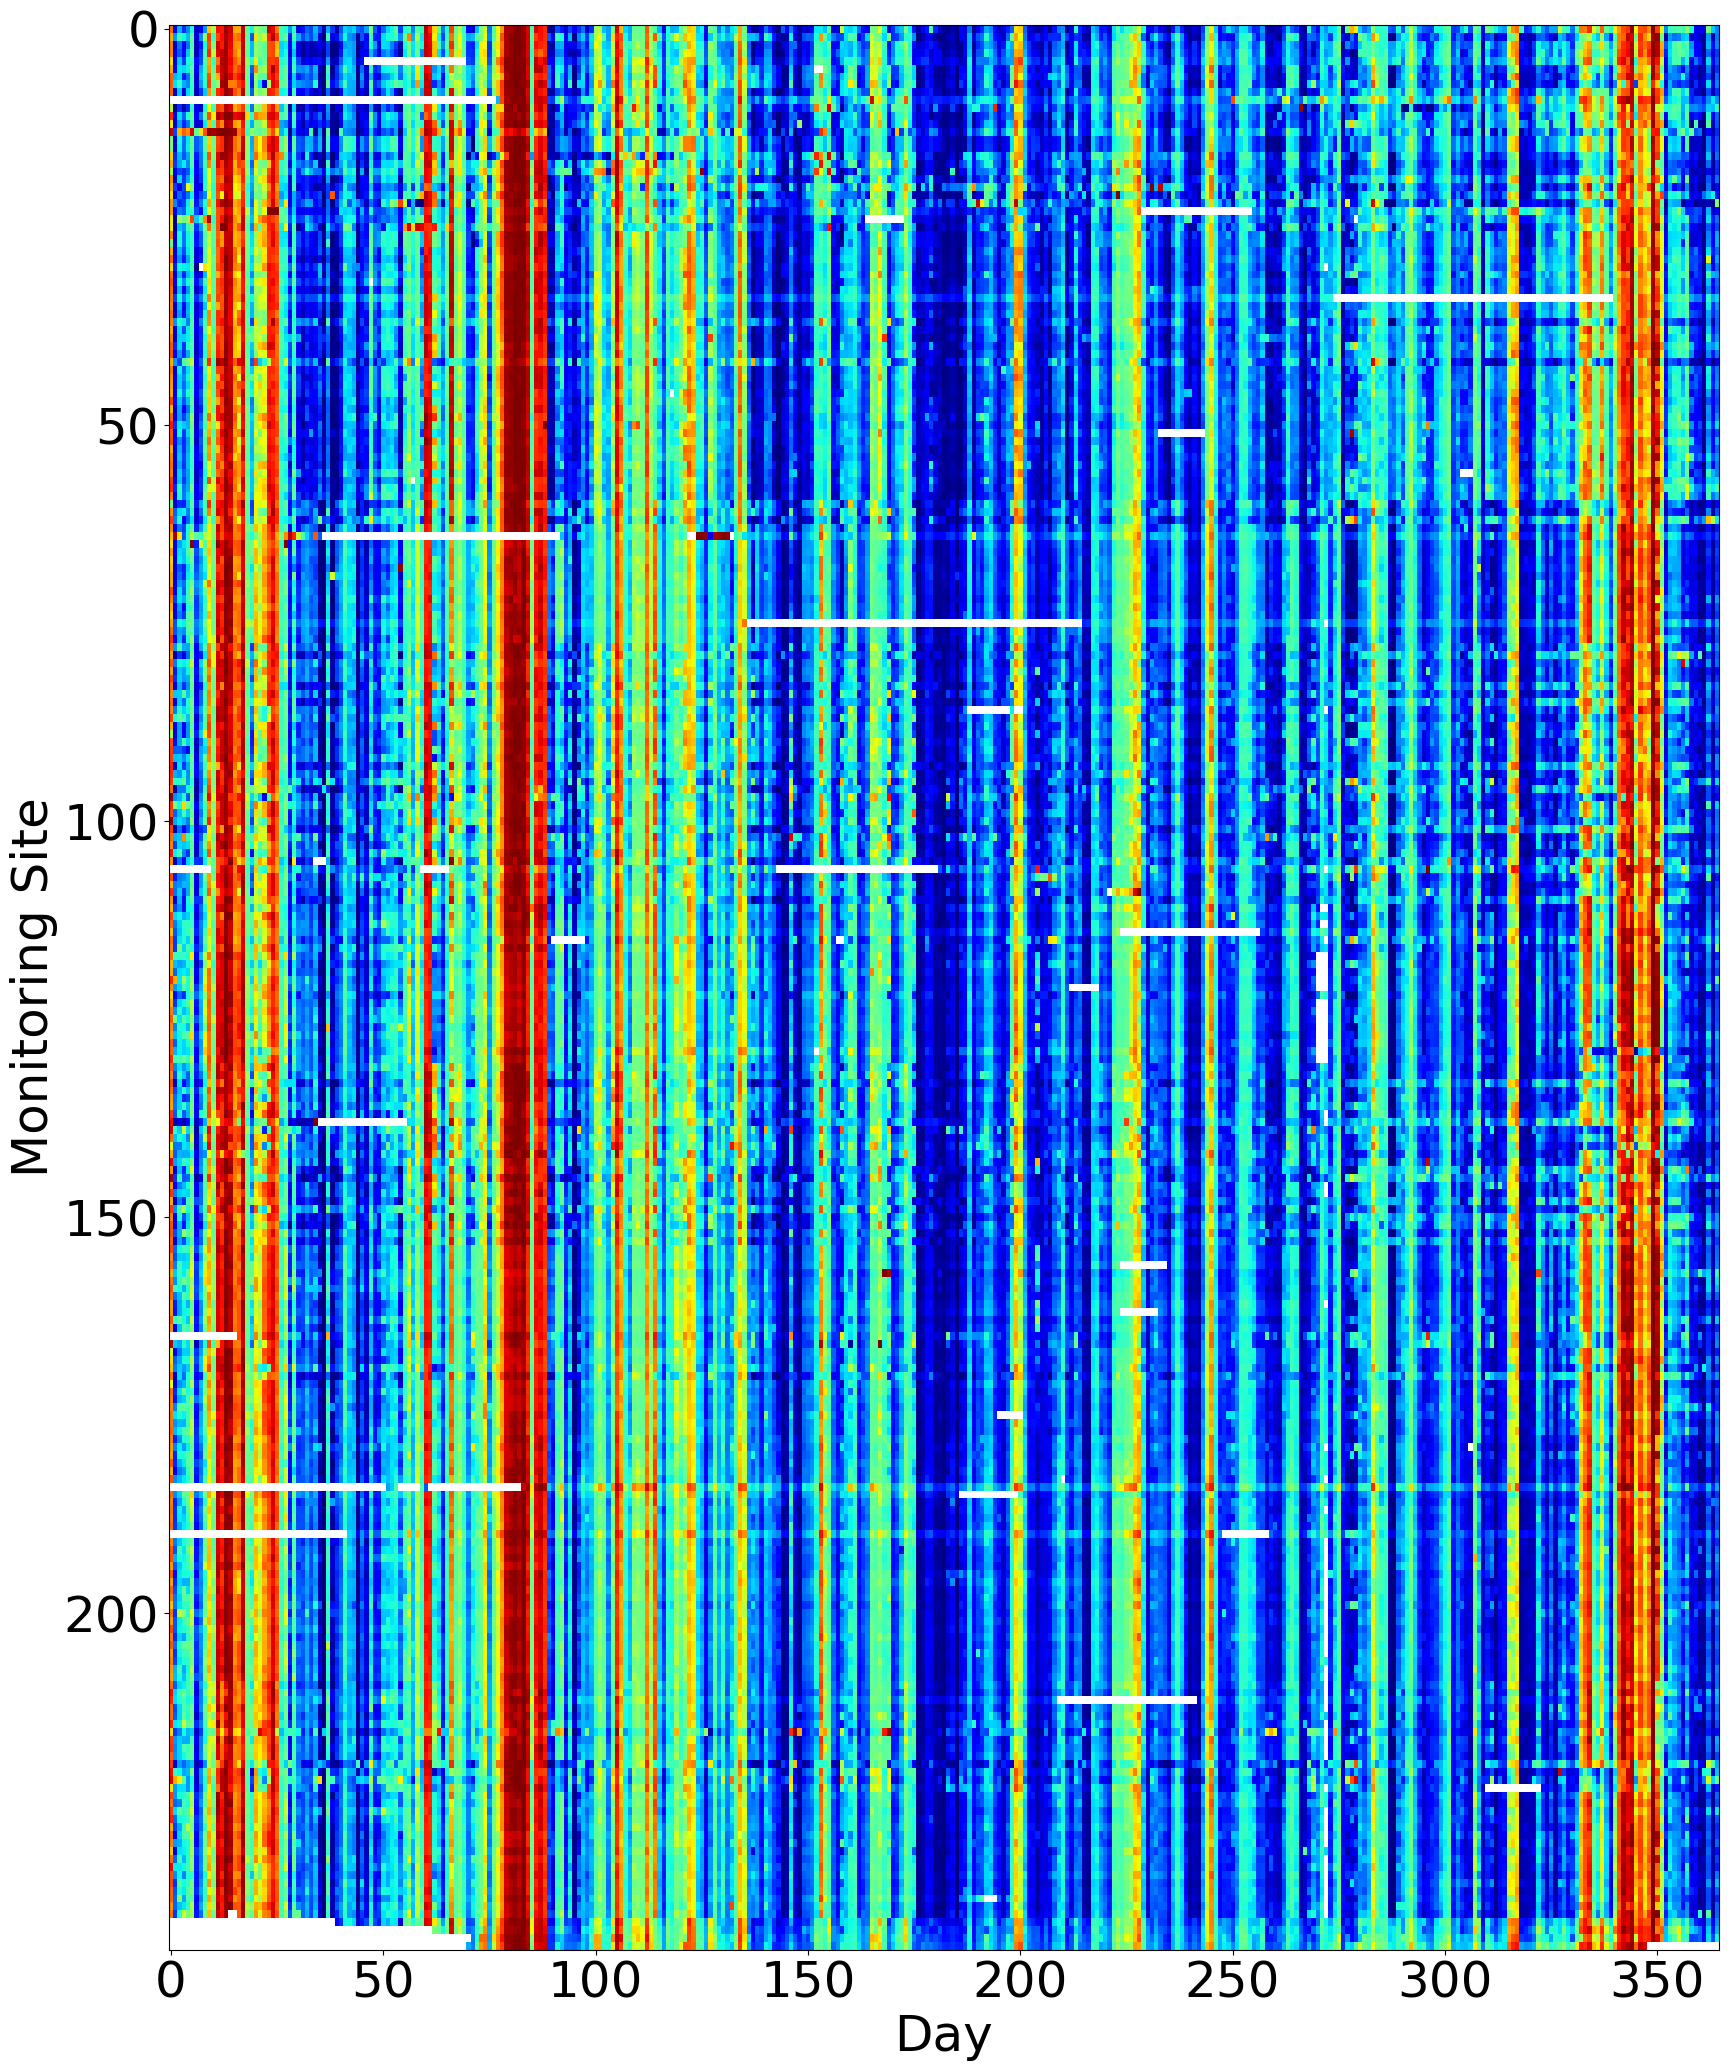

In [17]:
typ = "PM$_{2.5}$"
plot_intraranking(matrk, typ, nsite, totd2, (20,25), True)

In [46]:
# creating csv file of regional driver days
thldrgnl1 = 0.95 # at one monitoring site, top (thldrgnl1*100)% days --> higher concentrations.
thldrgnl2 = 0.95 # On one day, more than (thldrgnl2*100)% of the monitoring sites are considered as with higher concentrations
matrkfinal = matrk[siteoi.astype(int),:]
matrkjudge = np.zeros([len(siteoi),totd2])
for i in np.arange(0,len(siteoi)):
    for j in np.arange(0,totd2):
        if matrkfinal[i,j] > np.floor(totd*thldrgnl1):
            matrkjudge[i,j] = 1

nsiteavail = len(siteoi)-np.sum(np.isnan(matrkfinal),axis=0)
indreg = np.where((np.sum(matrkjudge,axis=0)/nsiteavail)>thldrgnl2)[0]

dti = pd.date_range("2022-01-01", periods=totd, freq="D") #fix here for time range
    
dateregdf = pd.DataFrame(dti[indreg])

dateregdf.to_csv('Date_Regional_Driver.csv')

In [47]:
dateregdf

,0
0,2022-01-14
1,2022-01-15
2,2022-03-21
3,2022-03-22
4,2022-03-23
5,2022-03-24
6,2022-03-25
7,2022-12-16


In [48]:
# removing regional driver days from mudpm and mudno2
hour = ['00','01','02','03','04','05','06','07','08','09','10','11',
        '12','13','14','15','16','17','18','19','20','21','22','23',]

for d in range(len(dateregdf)):
    date = dateregdf.iloc[d][0]
    i = vecday.get_loc(date)
    mudpm = np.delete(mudpm, (i), axis=0)
    mudno2 = np.delete(mudno2, (i), axis=0)
    vecday = vecday.drop(vecday[i])
    for h in hour:
        dt = f"{date.date()} {h}:00:00"
        data.drop(dt, axis=0, inplace=True, errors='ignore')
        
totd2 = len(mudpm)

## Inter-Ranking System

In [53]:
def interranking(mud, indtype):
    """Interrranking matrix function that returns the interranking matrix, min and max of matrix. 
    The idea is the same as the intra-ranking system - but ranked by monitoing site instead of ranked by day.
    
    Parameters:
    mud: daily mean data either mudpm or mudno2
    indtype: index of all the sites of interest
    
    Outputs: 
    mat_rk: interranking matrix mat_rk that is totd by len(indtype)
    _min: Min of mat_rk
    _max: Max of mat_rk
    """
    nn = len(indtype) #number of monitoring sites
    totd = len(mud)

    mat_rk = np.zeros([nn, totd])
    for i in np.arange(0,totd):
        valsort = np.sort(mud[i,indtype])[::-1]
        isort = np.argsort(mud[i,indtype])[::-1]
        valsort2 = valsort[~np.isnan(valsort)]
        isort2 = isort[~np.isnan(valsort)]
        mat_rk[isort2,i] = np.arange(nn-len(isort2)+1,nn+1)[::-1]
        ina = np.where(np.isnan(mud[i,indtype]))[0]
        if len(ina)!=0:
            mat_rk[ina,i] = np.ones([len(ina)])*np.nan

    _min, _max = np.nanmin(mat_rk), np.nanmax(mat_rk)
    
    return mat_rk, _min, _max

In [54]:
def interranking_plot(mat_rk, typ, sitetyp, figsize=(20,30), save=False):
    """Plots interranking matrix.
    
    Paramters:
    mat_rk: interranking matrix created from interranking function above
    nn: number of sites of interest
    typ: string representation denoting either PM 2.5 or NO2
    sitetyp: string of site classification "All", "Nightlife", etc.
    
    Outputs: implot of mat_rk"""
    nn, totd = mat_rk.shape
    fs=36
    fig = plt.figure(figsize=figsize)
    orig_cmap = matplotlib.cm.jet
    shifted_cmap = shiftedColorMap(orig_cmap, 0, 0.80, 1)

    plt.imshow(mat_rk, aspect='auto', cmap=shifted_cmap, origin='lower') #YlOrRd, seismic, bwr
    #plt.title(f'Inter-Ranking of {typ} Daily Average Concentations: {sitetyp} Sites',fontsize=fs)
    plt.xlabel('Day', fontsize=fs)
    plt.ylabel('Monitoring Site', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
#     cb = plt.colorbar(ticks=[1,totd*0.9, totd], shrink=1, aspect=30 , location='top')
#     cb.set_ticklabels(['Low','Top 10%','High'])
#     cb.ax.tick_params(labelsize=fs-2)
    
    if save:
        fig.savefig(f'graphs/{sitetyp}_interrk.png',bbox_inches='tight',dpi=500)

    plt.show()

In [55]:
def find_hotspots(mat_rk, data, thr, indtype, return_score=True):
    """
    Returns either the
    Parameters: 
    mat_rk: interranking matrix created from interranking function above
    data: Pm or No2 concentration dataframe
    thr:
    return_score: whether it reutrns list of weighted scores or site codes of hotspots
    indtype: list of monitoring site codes of interest
    """
    nn, totd = mat_rk.shape

    navildp = np.count_nonzero(~np.isnan(mat_rk),axis=1) # array counting number of non nan days per monitering site
    nn_per_day = np.count_nonzero(~np.isnan(mat_rk),axis=0) #sum of non nan sites per day

    #cthigh = np.zeros([nn])*np.nan
    w = np.zeros((nn,totd))*np.nan
    for i in np.arange(0,totd): # for each site
        w[:,i] = mat_rk[:,i]/nn #scaling the ranking of each day by number of sites per day
   
    score = np.nansum(w, axis=1)/navildp #dividing the weights by number of non nan days to get average annual weight

    if return_score:
        return score 
    else:
        return data.columns[np.array(indtype)[score>thr]]

#### Urban Background vs Roadside

In [50]:
dst = 5 # distance from road in meters to divide between roadside and urban background
roadside = basicinfo[basicinfo['ToRoad'] < dst].index.tolist()
background = basicinfo[basicinfo['ToRoad'] >= dst].index.tolist()

In [51]:
siteoi = siteoi.astype(int)  # all sites of interest
roadside = list(set(roadside) & set(siteoi))
background = list(set(background) & set(siteoi))

#### Hotspots and Interranking for Roadside and Urban Background

In [64]:
# roadside
roadside_mtr, roadside_min, roadside_max = interranking(mudpm, roadside)
find_hotspots(roadside_mtr, data ,0.84, roadside, False)

Index(['CLDP0136', 'CLDP0271'], dtype='object')

In [ ]:
interranking_plot(roadside_mtr, typ, "Roadside", (20,15), True)

In [70]:
# urban background sites
background_mtr, background_min, background_max = interranking(mudpm, background)
find_hotspots(background_mtr, data, 0.88, background, False)

Index(['CLDP0010'], dtype='object')

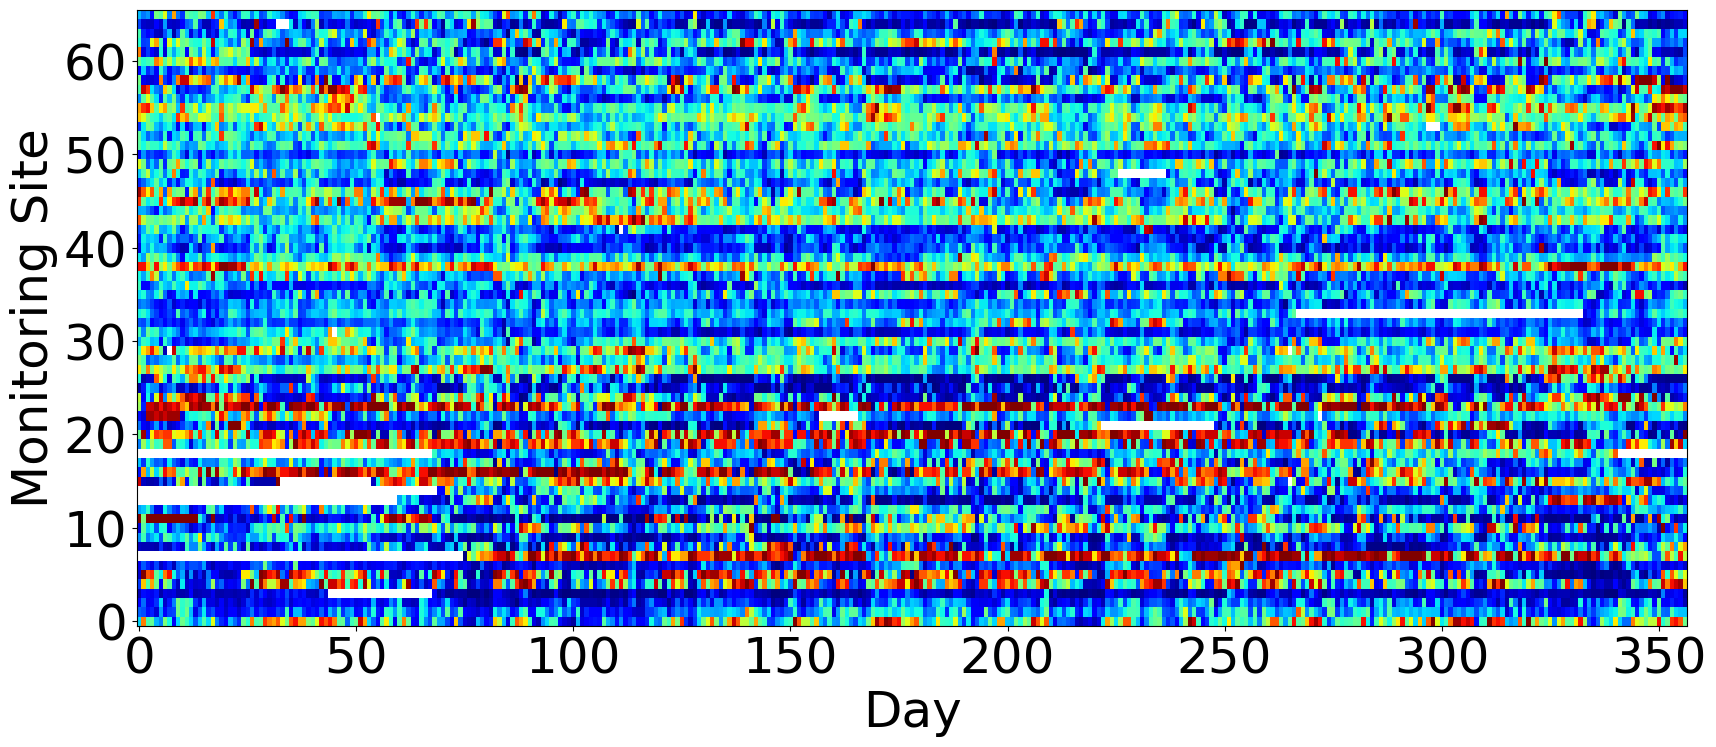

In [71]:
interranking_plot(background_mtr, typ, "Background",(20,8), True)

In [ ]:
def hotspot_interranking(mat_rk, _min, _max, ind_arr, indtype, typ, sitetyp, save=False):
    """
    Plots interranking of only the hotspots
    Parameters:

    mat_rk: interranking of sites of interest
    _min:
    _max:
    ind_arr: indexes of hotspots corresponding to column in concentration dataframe to graph
    indtype: indexes of overall site type (i.e. roadside, background)
    typ: string of PM2.5 or NO2
    sitetyp: string of site type of interest
    
    Outputs: interranking graph of just the hotspot sites
    """
    ind = np.where(np.in1d(indtype, ind_arr)==True) # index of hotspots in the interranking matrix
    nhp = len(ind_arr)
    _, totd = mat_rk.shape

    temp = mat_rk[ind].flatten().reshape(nhp, totd)
    
    fs=18
    fig = plt.figure(figsize=(20,nhp*3/8))

    orig_cmap = matplotlib.cm.jet
    shifted_cmap = shiftedColorMap(orig_cmap, 0, 0.80, 1)

    plt.imshow(temp, aspect="auto", vmin=_min, vmax=_max, cmap=shifted_cmap, origin='lower') 

    plt.title(f'{typ} Hotspot Inter-Ranking of Daily Average Concentations: {sitetyp} Sites',fontsize=fs)
    plt.xlabel('Day', fontsize=fs)
    plt.ylabel('Site', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.yticks(np.arange(0,nhp),data.columns[ind_arr],fontsize=fs)

    plt.show()
    if save:
        fig.savefig(f'{typ}_{sitetyp}_hotspots.png',bbox_inches='tight',dpi=300)

In [ ]:
def plot_validation(mat_rk, data, indtype, sitetyp, t_st=0.50, t_end=1.0):
    """
    Plots line plots of the thresholds
    Inputs:
    mat_rk: interranking matrix
    data: concentration data
    indtype: site type
    sitetyp: text for plot title
    t_st: first threshold 1 value to test
    t_end: last threshold 1 value to test

    mat_rk: interranking matrix created from interranking function above

    Outputs: Line plots of the number of hotspots vs varying threshold values
    """
    t_lst = np.linspace(t_st,t_end, num=20)
    line = []
    for t in t_lst:
        line.append(len(find_hotspots(mat_rk, data, t, indtype, False))) 
    plt.plot(t_lst, line)
    plt.title(f"Elbow Curve for Hotspot Threshold: {sitetyp} Sites")
    plt.xlabel("Threshold for Top Ranking Days")
    plt.ylabel("Number of Hotspots")

In [ ]:
plot_validation(roadside_mtr, data, roadside, "Roadside")

In [ ]:
plot_validation(background_mtr, data, background, "Urban Background")

In [ ]:
#hotspot indices
roadsidehp = ['CLDP0136', 'CLDP0271']#interested sites
roadsideind = [data.columns.get_loc(i) for i in roadsidehp]

In [ ]:
hotspot_interranking(roadside_mtr, roadside_min, roadside_max, roadsideind, roadside, typ, "Roadside", True)

In [ ]:
#hotspot indices
backgroundhp = ['CLDP0010']#interested sites
backgroundind = [data.columns.get_loc(i) for i in backgroundhp]

In [ ]:
hotspot_interranking(background_mtr, background_min, background_max, backgroundind, background, typ, "Background", True)

#### Corresponding Interranking Plot (NO2 or PM2.5)

In [ ]:
cor_rd_mtr, corr_rd_min, corr_rd_max = interranking(mudno2, roadside)
hotspot_interranking(cor_rd_mtr, corr_rd_min, corr_rd_max, roadsideind, roadside, "NO$_2$", "Roadside")

In [ ]:
# no NO2 data available
cor_ub_mtr, corr_ub_min, corr_ub_max = interranking(mudno2, background)
hotspot_interranking(cor_ub_mtr, corr_ub_min, corr_ub_max, [26], background, "NO$_2$", "Urban Background")

#### Inversely related hotspot sites

In [ ]:
rd_pm_score = find_hotspots(roadside_mtr, pm, 0.8, roadside)
ub_pm_score = find_hotspots(background_mtr, pm, 0.87, background)

rd_no2_score = find_hotspots(cor_rd_mtr, no2, 0.87, roadside)
ub_no2_score = find_hotspots(cor_ub_mtr, no2, 0.87, background)

In [ ]:
def plot_inverse_sites(pm_score, no2_score, data, ind, pm_mtr, pm_min, pm_max, no2_mtr, no2_min, no2_max, 
                       sitetype, top=5):
    """
    Plots the PM2.5 and No2 interranking plots of top X sites with biggest difference between PM2.5 and NO2 Scores.
    pm_score: np array pm2.5 weights for the ranking of sites
    no2_score: np array no2 weights for the ranking of sites
    ind: list of indexes of each site corresponding to site data 
    data: contains site info for all sites
    mtr: inter-ranking matrix """
    
    mask = ~np.isnan(pm_score - no2_score)
    diff = (pm_score-no2_score)[mask]
    ind_nonnan = np.array(ind)[mask]
    
    tmp = np.argsort(diff)[-top:] #argsort to get indexes of top X sites
    dataind = np.flip(ind_nonnan[tmp]) # index of sites 
    
#     plt.subplot()
    hotspot_interranking(pm_mtr, pm_min, pm_max, dataind, ind, "PM$_2.5$", sitetype)
    hotspot_interranking(no2_mtr, no2_min, no2_max, dataind, ind, "NO$_2$", sitetype)

In [ ]:
plot_inverse_sites(rd_pm_score, rd_no2_score, data, roadside, roadside_mtr, roadside_min, roadside_max, 
                   cor_rd_mtr, corr_rd_min, corr_rd_max, "Roadside")

In [ ]:
roadsidehp = ['CLDP0136', 'CLDP0271']#interested sites
roadsideind = [data.columns.get_loc(i) for i in roadsidehp]
hotspot_interranking(roadside_mtr, roadside_min, roadside_max, roadsideind, roadside, typ, "Roadside")

## Download CSV data

In [ ]:
# download data
pm.to_csv('2022_pm25.csv')
no2.to_csv('2022_no2.csv')

In [ ]:
# download siteinfo, resetting index for only sites of interest
siteinfo = basicinfo.iloc[siteoi]
siteinfo = siteinfo.reset_index().drop(columns=['index'])
siteinfo.to_csv('site_info.csv')

In [ ]:
# no2clustering = no2clustering.iloc[:,siteoi]
# no2siteinfo = basicinfo.iloc[siteoi]

# no2siteinfo.to_csv('no2_site_info.csv')
# no2clustering.to_csv('no2_clustering.csv')

In [ ]:
sitecodelisttemp = ['CLDP0210', 'CLDP0271']
fs=14
fig  = plt.figure(figsize=(25,4))

for i in np.arange(0,nn):
    plt.plot(np.arange(indt1,indt2+1),cpm.iloc[indt1:indt2+1,i], color='lightgray')

for j in sitecodelisttemp:
    indtemp = np.where(cpm.columns==j)[0][0]
    plt.plot(np.arange(indt1,indt2+1),cpm.iloc[indt1:indt2+1,indtemp], label=f'{j}')

plt.legend(fontsize=fs)
plt.xlim([indt1,indt2+1])
plt.ylim([0,250])
plt.xlabel('Hour', fontsize=fs)
plt.show()

In [ ]:
sitecodetemp = 'CLDP0271'
indtemp = np.where(cpm.columns==sitecodetemp)[0][0]
basicinfo.iloc[indtemp,:]

In [ ]:
basicinfo['SitePhotoURL'][indtemp]

In [ ]:
basicinfo['SiteDescription'][indtemp]